### Celda 1: Importaciones y Configuración Global
Ejecuta esto primero para cargar todas las librerías necesarias.

In [2]:
# Celda 1
%pip install ultralytics easyocr
import os
from ultralytics import YOLO
import cv2
import easyocr
print("Librerías instaladas correctamente")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 11.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/Users/edithriostorres/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Librerías instaladas correctamente


In [3]:
# Celda 2: Crear el archivo de configuración data.yaml
import os

ruta_actual = os.getcwd()

contenido_yaml = f"""
path: {ruta_actual}/dataset  # Ruta base
train: train/         # Carpeta de imágenes de entrenamiento
val: valid/           # Carpeta de imágenes de validación

# Clases (nombres)
nc: 1
names: ['licence']
"""

with open('data.yaml', 'w') as f:
    f.write(contenido_yaml)

print("✅ Archivo data.yaml creado exitosamente.")

✅ Archivo data.yaml creado exitosamente.


In [5]:
import os
import cv2
import shutil

# Ajusta estas rutas a donde tengas tu carpeta dataset
# IMPORTANTE: Haz una copia de seguridad de tu carpeta dataset antes de correr esto por si acaso.
CARPETA_RAIZ = "dataset" 
CONJUNTOS = ["train", "valid", "test"]

def convertir_formato_a_yolo():
    print("🚀 Iniciando conversión de _annotations.txt a formato YOLO...")
    
    for conjunto in CONJUNTOS:
        ruta_conjunto = os.path.join(CARPETA_RAIZ, conjunto)
        ruta_txt = os.path.join(ruta_conjunto, "_annotations.txt")
        
        if not os.path.exists(ruta_txt):
            print(f" No se encontró anotaciones en {conjunto}, saltando...")
            continue
            
        print(f"📂 Procesando: {conjunto}...")
        
        with open(ruta_txt, 'r') as f:
            lineas = f.readlines()
            
        contador = 0
        for linea in lineas:
            partes = linea.strip().split()
            if not partes: continue
            
            nombre_imagen = partes[0]
            coords_raw = partes[1:]
            
            ruta_img = os.path.join(ruta_conjunto, nombre_imagen)
            

            img = cv2.imread(ruta_img)
            if img is None: continue
            h_img, w_img = img.shape[:2]
            
            contenido_yolo = []
            
            for caja in coords_raw:
                try:
                    
                    vals = list(map(float, caja.split(',')))
                    x_min, y_min, x_max, y_max, class_id = vals
                    
                    # Conversión a YOLO (x_centro, y_centro, ancho, alto) NORMALIZADO (0 a 1)
                    w_box = x_max - x_min
                    h_box = y_max - y_min
                    x_center = x_min + (w_box / 2)
                    y_center = y_min + (h_box / 2)
                    
                    x_c_norm = x_center / w_img
                    y_c_norm = y_center / h_img
                    w_norm = w_box / w_img
                    h_norm = h_box / h_img
                    
                    # Formato YOLO: clase x_c y_c w h
                    contenido_yolo.append(f"{int(class_id)} {x_c_norm:.6f} {y_c_norm:.6f} {w_norm:.6f} {h_norm:.6f}")
                except ValueError:
                    continue
            
            # Guardar archivo .txt individual
            nombre_txt = os.path.splitext(nombre_imagen)[0] + ".txt"
            ruta_destino_txt = os.path.join(ruta_conjunto, nombre_txt)
            
            with open(ruta_destino_txt, 'w') as out_f:
                out_f.write('\n'.join(contenido_yolo))
            
            contador += 1
            
        print(f"✅ {conjunto}: Se crearon {contador} archivos .txt de etiquetas.")

convertir_formato_a_yolo()

🚀 Iniciando conversión de _annotations.txt a formato YOLO...
📂 Procesando: train...
✅ train: Se crearon 507 archivos .txt de etiquetas.
📂 Procesando: valid...
✅ valid: Se crearon 105 archivos .txt de etiquetas.
📂 Procesando: test...
✅ test: Se crearon 62 archivos .txt de etiquetas.


In [6]:
# Celda 3: Entrenar el modelo
# Cargar modelo pre-entrenado
model = YOLO('yolov8n.pt') 

# Entrenar
results = model.train(data='data.yaml', epochs=20, imgsz=640)

print("✅ Entrenamiento terminado.")

Ultralytics 8.3.230 🚀 Python-3.10.10 torch-2.9.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, p

In [12]:
# Celda 4: Ejecutar Webcam con Detección + OCR (Corregido para Mac)
import cv2
import easyocr
import math
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# ------------------------

# Cargar el modelo YOLO entrenado
ruta_modelo = 'runs/detect/train2/weights/best.pt'
model = YOLO(ruta_modelo) 

print("⏳ Cargando OCR ...")
# Inicializar OCR (ahora sí debería descargar sin error)
reader = easyocr.Reader(['es'], gpu=False) 

cap = cv2.VideoCapture(0)

print("📷 Iniciando cámara...")

while True:
    ret, frame = cap.read()
    if not ret: break

    # 1. Detección con YOLO
    resultados = model(frame, stream=True, verbose=False)

    for r in resultados:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            confianza = math.ceil((box.conf[0]*100))/100
            
            if confianza > 0.5:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                
                # 2. Recortar e intentar leer
                try:
                    placa_recorte = frame[y1:y2, x1:x2]
                    texto_detectado = reader.readtext(placa_recorte)
                    
                    if len(texto_detectado) > 0:
                        texto_placa = texto_detectado[0][1]
                        
                        # Dibujar texto
                        cv2.rectangle(frame, (x1, y1-40), (x1+200, y1), (0,0,0), -1)
                        cv2.putText(frame, texto_placa.upper(), (x1, y1 - 10), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
                        
                        print(f"Placa: {texto_placa}")
                except Exception:
                    pass

    cv2.imshow('Detector Final', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Using CPU. Note: This module is much faster with a GPU.


⏳ Cargando OCR (esto puede tardar un poco la primera vez)...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete📷 Iniciando cámara...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Placa: HI
Placa: HUJ 'a
Placa: IKLU-94-69
Placa: HLU-94-69
Placa: KLU-94-69
Placa: FLU-94-69
Placa: HLU-94-69
Placa: KLU-94-69
Placa: ALIJ-94-69
Placa: ALIJ-94-69
Placa: HLU-94-69
Placa: HLU-94-62
Placa: HLU-94-69
Placa: HLU-94-69
Placa: KLU-94-69
Placa: HLU-94-69
Placa: KLU-94-63
Placa: KLU-94-69
Placa: KLU-94-69
Placa: KLU-94-69
Placa: HLU-94-69
Placa: 27
Placa: co
Placa: gcogla
Placa: eom
Placa: KLU-94-69
Placa: HLU-94-69
Placa: HLU-94-69
Placa: HLU-94-69]
Placa: HLU-94-69
Placa: HLU-94-69
Placa: DVMTI
Placa: HLU-94-69
Placa: HLU-94-69
Placa: Duye
Placa: HLU-94-69
Placa: DllAyTtu
Placa: DVMIu
Placa: 8MIRA
Placa: 0
Placa: Dluyu
Placa: Dila
Placa: D
Placa: 0
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: CDM 
Placa: KLU-94-69
Placa: 94-69
Placa: CDMX
Placa: CDMX
Placa: CDMX
Placa: PLB
Placa: [GR8 PL8
Placa: GR8 PL8
Placa: GR8 PL8
Placa: GR8 PL8
Pl

: 

Using CPU. Note: This module is much faster with a GPU.


⏳ Cargando modelos...
✅ Se encontraron 62 imágenes para probar.

🚗 Imagen: WhatsApp-Image-2022-04-04-at-2-25-09-PM_jpeg.rf.c074f2f4b470950febea9d28db1fd88f.jpg | 🔍 Placa Detectada: {ssilgGl1es0 NHG-96-02 Santa (Confianza: 0.87)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


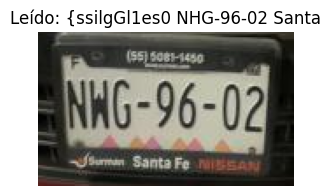

🚗 Imagen: IMG_7039-conv_jpeg.rf.5c142c20a8b8ce93ecd9eb0592e973f4.jpg | 🔍 Placa Detectada: 198-4 HFT - (Confianza: 0.91)


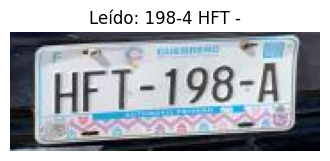

🚗 Imagen: 2970041007_a152861bca_jpg.rf.bea226acf0c06c2d079391e3d5ddcca2.jpg | 🔍 Placa Detectada: 2òr Y7TL (Oahada (Confianza: 0.83)


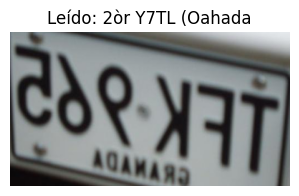

🚗 Imagen: 3201442039_f846497dc7_jpg.rf.7a270ff26b778a6e1f34f3200e2251ec.jpg | 🔍 Placa Detectada: 7ap570 (Confianza: 0.89)


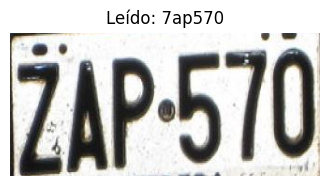

🚗 Imagen: 2735552293_1df90f0e47_jpg.rf.7eafb6a62bd3be81fcc365241e2aabd0.jpg | 🔍 Placa Detectada: VED 740 (Confianza: 0.90)


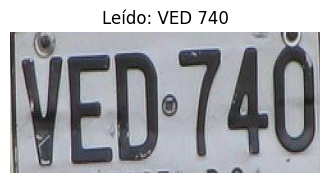


🏁 Prueba finalizada.


In [1]:
import os
import cv2
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. Configuración
ruta_modelo = 'runs/detect/train2/weights/best.pt' # Tu modelo entrenado
carpeta_test = 'dataset/test' # Tus imágenes de prueba que la IA no conoce

# Cargar modelos
print("⏳ Cargando modelos...")
model = YOLO(ruta_modelo)
reader = easyocr.Reader(['es'], gpu=False)

# Obtener lista de imágenes
imagenes_test = [f for f in os.listdir(carpeta_test) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"✅ Se encontraron {len(imagenes_test)} imágenes para probar.\n")

# 2. Bucle de prueba
for imagen_nombre in imagenes_test[:5]: # Probamos solo las primeras 5 para no saturar (quita el [:5] para todas)
    ruta_img = os.path.join(carpeta_test, imagen_nombre)
    frame = cv2.imread(ruta_img)
    
    # Detección (YOLO)
    resultados = model(frame, verbose=False)
    
    detectado = False
    
    for r in resultados:
        for box in r.boxes:
            # Coordenadas
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confianza = float(box.conf[0])
            
            # Recortar placa
            placa_img = frame[y1:y2, x1:x2]
            
            # Lectura (OCR)
            # detail=0 solo devuelve el texto
            texto = reader.readtext(placa_img, detail=0) 
            
            if texto:
                texto_final = " ".join(texto)
                print(f"🚗 Imagen: {imagen_nombre} | 🔍 Placa Detectada: {texto_final} (Confianza: {confianza:.2f})")
                
                # Mostrar imagen con recorte (Opcional, para ver en el notebook)
                plt.figure(figsize=(4, 2))
                plt.imshow(cv2.cvtColor(placa_img, cv2.COLOR_BGR2RGB))
                plt.title(f"Leído: {texto_final}")
                plt.axis('off')
                plt.show()
                detectado = True
                
    if not detectado:
        print(f"❌ Imagen: {imagen_nombre} | No se detectó ninguna placa.")

print("\n🏁 Prueba finalizada.")

In [3]:
import os

# 1. Detectamos en qué carpeta estás EXACTAMENTE ahora
ruta_actual = os.getcwd()
ruta_dataset = os.path.join(ruta_actual, "dataset")

# 2. Verificamos las carpetas reales
# A veces se llama 'valid', a veces 'val'. Ajustamos automático.
if os.path.exists(os.path.join(ruta_dataset, "valid")):
    val_folder = "valid"
else:
    val_folder = "val"

# 3. Creamos el contenido con la RUTA COMPLETA (Absolute Path)
# Esto le dice a YOLO: "No adivines, los archivos están AQUÍ"
contenido_yaml = f"""
path: {ruta_dataset}
train: train
val: {val_folder}
test: test

nc: 1
names: ['placa']
"""

# 4. Sobrescribimos el archivo data.yaml
with open('data.yaml', 'w') as f:
    f.write(contenido_yaml)

print("✅ Archivo data.yaml corregido.")
print("📂 Ahora apunta a:", ruta_dataset)
print("📄 Contenido nuevo:\n", contenido_yaml)

✅ Archivo data.yaml corregido.
📂 Ahora apunta a: /Users/edithriostorres/Desktop/REPOSITORISO/Topicos_IA/Unidad4/ProyectoDeteccionPlacas/ModeloDetectorPlacas/dataset
📄 Contenido nuevo:
 
path: /Users/edithriostorres/Desktop/REPOSITORISO/Topicos_IA/Unidad4/ProyectoDeteccionPlacas/ModeloDetectorPlacas/dataset
train: train
val: valid
test: test

nc: 1
names: ['placa']



In [4]:
# Evaluar el modelo en el conjunto de validación o test
metrics = model.val(data='data.yaml', split='test')

print(f"Precision (Qué tanto acierta cuando dice que es placa): {metrics.box.map50:.2%}")
print(f"Recall (Cuántas placas reales encontró del total): {metrics.box.map:.2%}")

Ultralytics 8.3.230 🚀 Python-3.10.10 torch-2.9.1 CPU (Apple M1)
val: Fast image access ✅ (ping: 0.3±0.3 ms, read: 119.1±22.0 MB/s, size: 37.3 KB)
val: Scanning /Users/edithriostorres/Desktop/REPOSITORISO/Topicos_IA/Unidad4/ProyectoDeteccionPlacas/ModeloDetectorPlacas/dataset/test... 62 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 62/62 2.4Kit/s 0.0s
val: New cache created: /Users/edithriostorres/Desktop/REPOSITORISO/Topicos_IA/Unidad4/ProyectoDeteccionPlacas/ModeloDetectorPlacas/dataset/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 3.0s/it 11.9s5.3ss
                   all         62         62      0.997          1      0.995      0.851
Speed: 1.9ms preprocess, 184.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /Users/edithriostorres/Desktop/REPOSITORISO/Topicos_IA/Unidad4/ProyectoDeteccionPlacas/ModeloDetectorPlacas/runs/detect/val2
Precision (Qué tanto acierta cuando dice que